### Debug fitting GP with noise

In [4]:
from collections import namedtuple

import numpy as np

arrays_file = np.load("kernel-pca-debug-data.npz", allow_pickle=True)
my_arrays = {k: arrays_file[k] for k in arrays_file.files}
print("Creating objective function f:", my_arrays["f_"][0])
exec(my_arrays["f_"][0])
DummyBO = namedtuple("DummyBO", ["X_", "y_", "bounds"])
bo = DummyBO(X_=my_arrays["X_"], y_=my_arrays["y_"], bounds=my_arrays["bounds"])

X_ = my_arrays["X_"]
y_ = my_arrays["y_"]
bounds_ = my_arrays["bounds"]

import ioh

f = ioh.get_problem(
    fid=22, instance=1, dimension=2, problem_class=ioh.ProblemClass.BBOB
)

Creating objective function f: import ioh; f = ioh.get_problem(fid=22, instance=1, dimension=2, problem_class=ioh.ProblemClass.BBOB)


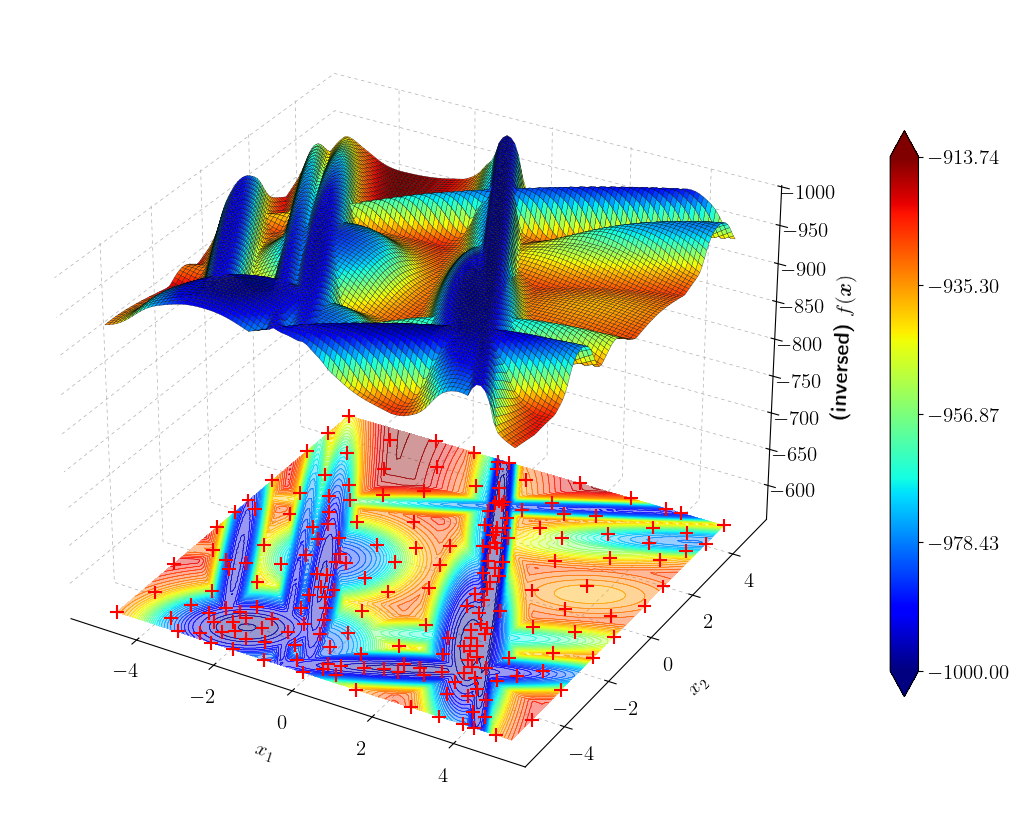

In [3]:
import FewShotCVRP.utils.plots as myplots

myplots.good_plt_config()

fig, ax = myplots.plot_3D_surface(
    (-5, 5),
    (-5, 5),
    f,
    X_,
    is_axis_names=True,
    is_white_facecolor=True,
    is_colorbar=True,
    discretization=100,
    zfactor=2.0,
    is_inverse=True,
)

In [9]:
import FewShotCVRP.bo.kpcabo.kpcabo_torch as kpcabo_torch

mapper = kpcabo_torch.KernelPCAMapper(
    bounds=bounds_, eta=0.66, pad_frac=0.1, random_state=1
)
mapper.fit(X_, y_)
Z = mapper.transform(X_, y_)
print(Z.shape)

(204, 1)


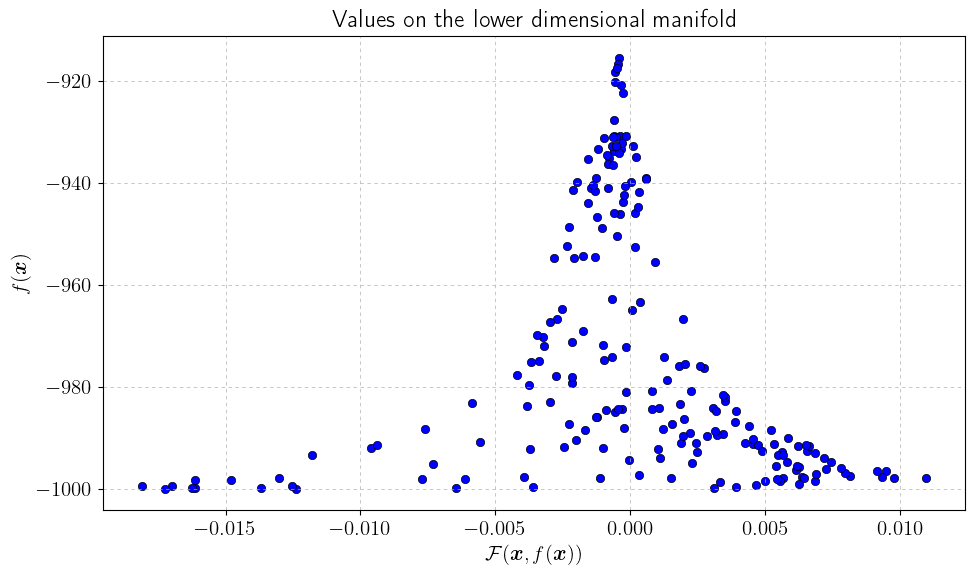

In [10]:
# Импортируем необходимые библиотеки
import matplotlib.pyplot as plt
import numpy as np

x = Z[:, 0]
y = y_

plt.figure(figsize=(10, 6))  # Размер фигуры в дюймах
plt.scatter(x, y,  ec="k", lw=0.5, alpha=1, color="blue", linestyle="-", marker="o")
plt.title("Values on the lower dimensional manifold")
plt.xlabel(r"$\mathcal{F}\!\br{\bm{x}, f(\bm{x})}$")
plt.ylabel(r"$f(\bm{x})$")

# Отображаем график
plt.tight_layout()  # Автоматическое расположение элементов
plt.show()

In [89]:
from importlib import reload
import FewShotCVRP.bo.gp_fitting as gp_fitting
import FewShotCVRP.bo.bo_torch as bo_torch
import FewShotCVRP.utils.logs as logs

reload(gp_fitting)
reload(bo_torch)

logs.configure_logger("FewShotCVRPLogger")

mll_fit_cfg = gp_fitting.MLLFitConfig(
    noise_bounds=(1.0, 1000.0),
    init_lengthscales_with_vanilla_bo=True,
    refine_with_grad=True,
    verbose=False,
)

bo_cfg = {
    "n_init": None,
    "n_iter": 50,
    "sigma": 10.0,
    "kernel": "matern",
    "matern_nu": 2.5,
    "kernel_isotropic": False,
    "use_input_normalize": True,
    "normalize_y": True,
    "add_vanilla_bo_prior": True,
    "acq_function": "logEI",
    "n_init_samples_acq_opt": 10_000,
    "n_restarts_acq_opt": 100,
    "suggestions_per_step": 10,
    "diversity_frac": 0.1,
    "doe_method": "precomputed",
}

bo = bo_torch.BayesianOptimizer(
    None,
    f_batch=None,
    bounds=mapper.z_bounds(),
    X_init=Z,
    y_init=y_,
    random_state=1,
    mll_fit_config=mll_fit_cfg,
    **bo_cfg,
)

bo._initialize_design()
bo._fit_gp()

[09/20/25 19:17:54] INFO     Found lengthscales parameters, shape: torch.Size([1])

                    INFO     Found constant mean parameter, shape: torch.Size([])

                    INFO     GP fitting initial log likelihood: -3.169397

[09/20/25 19:18:07] INFO     GP fitting after CMA-ES log likelihood: -1.254093

                    INFO     GP fitting final log likelihood: -1.254093 | status=1

                    INFO     fit_gp took 0:00:13.022416

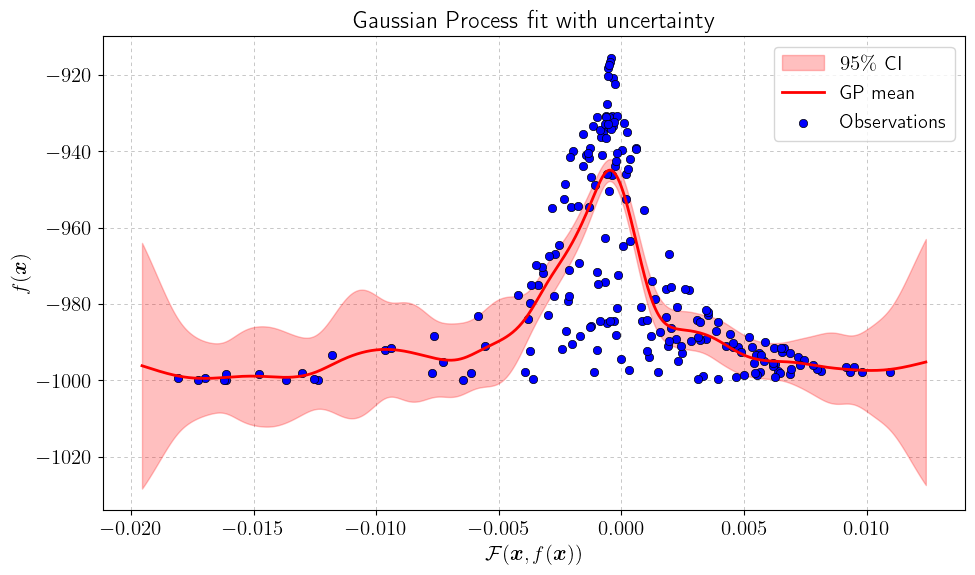

In [90]:
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt


def plot_gp_1d(gp, x, y, n_grid=500, n_samples=0, ax=None):
    """
    Plot a 1D GaussianProcessRegressor fit with uncertainty.
    Assumes gp is already fitted on (x[:, None], y).
    """
    x = np.asarray(x).ravel()
    y = np.asarray(y).ravel()

    # Build a dense grid with a small margin around data range
    ptp = np.ptp(x) if x.size > 1 else 1.0  # <-- fixed here
    margin = 0.05 * ptp
    x_min, x_max = x.min() - margin, x.max() + margin
    X_plot = np.linspace(x_min, x_max, n_grid).reshape(-1, 1)

    # Predict posterior mean and std on the grid
    # mu, std = gp.predict(X_plot, return_std=True)
    mu, std = bo.posterior(bo_torch._as_t(X_plot, dtype=bo.dtype, device=bo.device))

    # Prepare axis
    created_ax = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
        created_ax = True

    # 95% confidence band
    ax.fill_between(
        X_plot.ravel(),
        mu - 1.96 * std,
        mu + 1.96 * std,
        alpha=0.25,
        label=r"$95\%$ CI",
        color="red",
        zorder=2,
    )

    # Posterior mean
    ax.plot(X_plot.ravel(), mu, lw=2, label="GP mean", color="red", zorder=3)

    # Optional: posterior samples
    if n_samples > 0:
        rng = np.random.default_rng()
        samples = rng.multivariate_normal(mu, std, size=n_samples)
        for s in samples:
            ax.plot(X_plot.ravel(), s, lw=1, alpha=0.7)

    # Training data
    ax.scatter(
        x, y, ec="k", lw=0.5, alpha=1, label="Observations", color="blue", zorder=2.5
    )

    ax.set_xlabel(r"$\mathcal{F}\!\br{\bm{x}, f(\bm{x})}$")
    ax.set_ylabel(r"$f(\bm{x})$")
    ax.set_title("Gaussian Process fit with uncertainty")
    ax.legend(loc="best")
    # ax.grid(True, alpha=0.2)

    if created_ax:
        plt.tight_layout()
        plt.show()


# --- usage example (gp is already fitted on (x[:, None], y)) ---
plot_gp_1d(bo.get_gp(), Z[:, 0], y_, n_grid=500, n_samples=0)

In [21]:
gp = bo.get_gp()
print(gp.covar_module)
mu, std = bo.posterior(bo_torch._as_t(Z, dtype=bo.dtype, device=bo.device))

MaternKernel(
  (raw_lengthscale_constraint): Positive()
)


(array([-951.26893434, -946.69502099, -947.91584848, -946.87888974,
        -989.89916355, -946.57200311, -946.58333443, -946.53327273,
        -947.49487851, -951.18106014, -948.61365957, -962.24685989,
        -952.02700458, -951.97084307, -964.29452597, -956.55520767,
        -962.29616299, -989.0159783 , -947.18293748, -946.60373485,
        -971.55048218, -949.09744756, -966.23837892, -947.05329751,
        -955.1104967 , -946.81785084, -995.23787995, -963.02369525,
        -973.46891163, -963.65779763, -978.85619121, -946.79534742,
        -947.48346217, -946.51615829, -946.55163537, -987.36943437,
        -949.85870691, -983.79859249, -971.92764561, -947.25787908,
        -946.98018983, -994.64899709, -956.64603167, -964.71041438,
        -986.77647062, -993.5262875 , -948.1636756 , -973.0180673 ,
        -995.03017667, -974.45983669, -964.97539872, -984.86890832,
        -991.709072  , -946.51620884, -996.66430181, -982.80948404,
        -953.55684037, -967.30494142, -995.13793

In [91]:
acqf = bo._build_ei_acqf()

In [47]:
Z_t = bo_torch._as_t(Z, dtype=bo.dtype, device=bo.device)
Z_acq = Z_t.unsqueeze(-2)
print(Z_acq)

acqf(Z_acq).squeeze(-1)

tensor([[[-1.1760e-03]],

        [[-4.1909e-04]],

        [[-2.2085e-04]],

        [[-3.7257e-04]],

        [[ 3.9402e-03]],

        [[-5.9551e-04]],

        [[-6.0148e-04]],

        [[-5.6866e-04]],

        [[-2.7170e-04]],

        [[ 4.2689e-05]],

        [[-1.5066e-04]],

        [[-1.9620e-03]],

        [[ 9.5296e-05]],

        [[-1.2313e-03]],

        [[-2.1112e-03]],

        [[-1.5634e-03]],

        [[ 5.9984e-04]],

        [[ 3.5227e-03]],

        [[-3.1681e-04]],

        [[-6.1114e-04]],

        [[-2.6964e-03]],

        [[-9.8641e-04]],

        [[-2.2585e-03]],

        [[-3.3861e-04]],

        [[-1.4620e-03]],

        [[-6.7916e-04]],

        [[ 6.5579e-03]],

        [[-2.0180e-03]],

        [[ 1.1095e-03]],

        [[-2.0643e-03]],

        [[-3.3878e-03]],

        [[-3.9176e-04]],

        [[-2.7322e-04]],

        [[-5.4568e-04]],

        [[-5.8311e-04]],

        [[ 2.4708e-03]],

        [[-1.0573e-03]],

        [[ 1.8213e-03]],

        [[ 1

tensor([-2.1355e+02, -3.4322e+02, -2.9600e+02, -3.3527e+02, -5.7259e+00,
        -3.4963e+02, -3.4917e+02, -3.5115e+02, -3.1096e+02, -2.1050e+02,
        -2.7363e+02, -8.9537e+01, -1.9446e+02, -2.0027e+02, -7.6774e+01,
        -1.3683e+02, -8.5890e+01, -7.0688e+00, -3.2287e+02, -3.4835e+02,
        -4.2001e+01, -2.6405e+02, -6.5946e+01, -3.2806e+02, -1.5337e+02,
        -3.3969e+02, -2.0064e+00, -8.4511e+01, -3.8037e+01, -8.0580e+01,
        -1.9667e+01, -3.3884e+02, -3.1138e+02, -3.5176e+02, -3.5044e+02,
        -9.8263e+00, -2.4447e+02, -1.5389e+01, -4.2750e+01, -3.2270e+02,
        -3.3105e+02, -2.6742e+00, -1.3588e+02, -7.4360e+01, -1.0740e+01,
        -3.1874e+00, -2.9154e+02, -3.6766e+01, -2.3569e+00, -3.2094e+01,
        -7.2850e+01, -1.3681e+01, -1.1143e+00, -3.5157e+02,  9.9557e-01,
        -1.0193e+01, -1.6965e+02, -5.9935e+01, -2.2007e+00, -1.9112e+00,
        -1.2012e+02, -1.1128e+02, -1.1338e+00, -3.4684e+02, -2.6618e+01,
        -1.5912e+00, -8.1362e-01, -3.4367e+02, -1.1

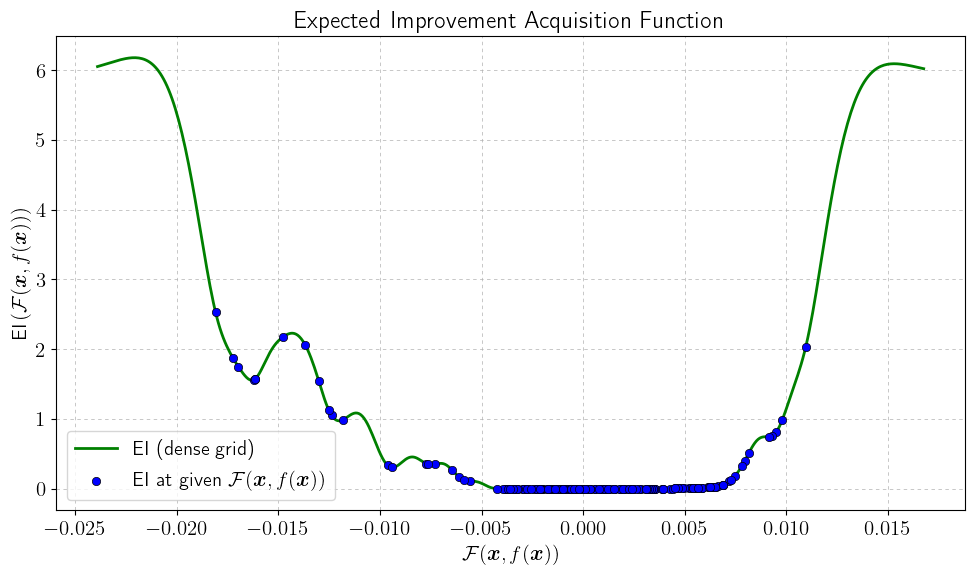

In [93]:
import numpy as np
import matplotlib.pyplot as plt


bo_ei = lambda Z_: np.exp(acqf(bo_torch._as_t(Z_, dtype=bo.dtype, device=bo.device).unsqueeze(-2)).squeeze(-1).detach().numpy())

def plot_ei(bo_ei, x, n_grid=500, ax=None):
    """
    Plot acquisition function bo_ei(x) at training points and on a dense grid.

    Parameters
    ----------
    bo_ei : callable
        Acquisition function, accepts 1D numpy array or list of scalars.
    x : (n,) array_like
        Input points where GP is trained or evaluated.
    n_grid : int
        Number of equally spaced points in the plot.
    ax : matplotlib.axes.Axes, optional
        Axis to draw on. If None, a new figure is created.
    """
    x = np.asarray(x).ravel()
    ptp = np.ptp(x) if x.size > 1 else 1.0
    margin = 0.2 * ptp
    x_min, x_max = x.min() - margin, x.max() + margin

    # Dense grid spanning the same range
    X_grid = np.linspace(x_min, x_max, n_grid)

    # Evaluate EI at grid and at given x
    y_grid = np.array([bo_ei([X_grid_i]) for X_grid_i in X_grid])
    y_x = np.array([bo_ei([x_i]) for x_i in x])

    # Prepare axis
    created_ax = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
        created_ax = True

    # Plot dense curve
    ax.plot(X_grid, y_grid, lw=2, label="EI (dense grid)", color="green")

    # Plot values at x
    ax.scatter(x, y_x, ec="k", lw=0.5, alpha=1, zorder=5, label=r"EI at given $\mathcal{F}\!\br{\bm{x}, f(\bm{x})}$", color="blue")

    ax.set_xlabel(r"$\mathcal{F}\!\br{\bm{x}, f(\bm{x})}$")
    ax.set_ylabel(r"$\text{EI}\br{\mathcal{F}\!\br{\bm{x}, f(\bm{x})}}$")
    ax.set_title("Expected Improvement Acquisition Function")
    ax.legend(loc="best")

    if created_ax:
        plt.tight_layout()
        # plt.show()
    return ax


ax_ei = plot_ei(bo_ei, Z[:, 0], n_grid=500)

[09/20/25 19:18:51] INFO     EI scores (selected): [1.79605, 1.76512] | baseline(start) ≈ -1.02243

                    INFO     argmax_acq took 0:00:00.095164

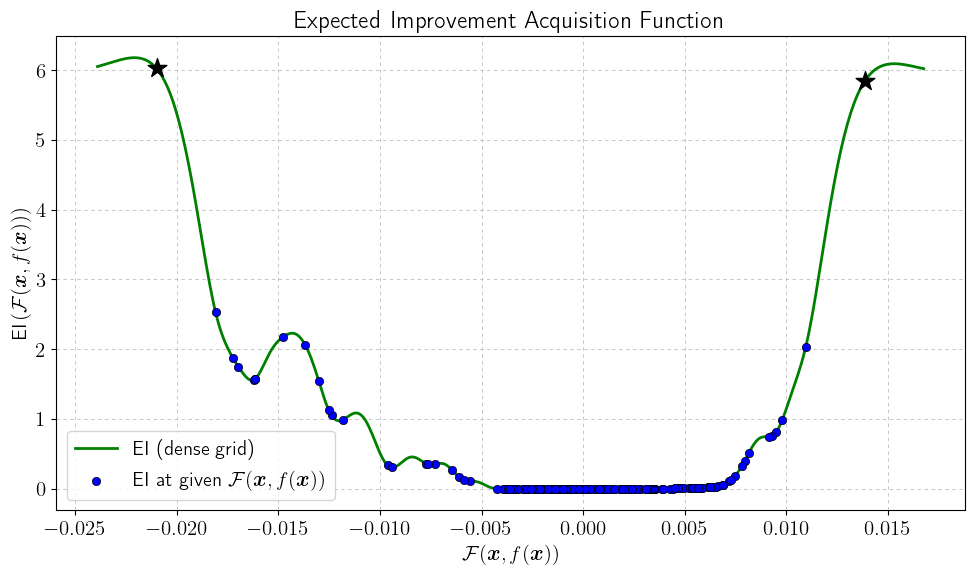

In [94]:
infill, _ = bo._argmax_acq_multi(5)
res_x = infill.detach().numpy().squeeze(-1)

ax_ei = plot_ei(bo_ei, x, n_grid=500)
ax_ei.scatter(res_x, [bo_ei([res_x_ith]) for res_x_ith in res_x], s=200, marker="*", color="black", zorder=5)

### End-to-end Kernel-PCA-BO

In [95]:
from importlib import reload
import FewShotCVRP.bo.gp_fitting as gp_fitting
import FewShotCVRP.bo.kpcabo.kpcabo_torch as kpcabo_torch
import FewShotCVRP.bo.bo_torch as bo_torch
import FewShotCVRP.utils.logs as logs

reload(gp_fitting)
reload(bo_torch)
reload(kpcabo_torch)

logs.configure_logger("FewShotCVRPLogger")

mll_fit_cfg = gp_fitting.MLLFitConfig(
    noise_bounds=(1.0, 1000.0),
    init_lengthscales_with_vanilla_bo=True,
    refine_with_grad=True,
    verbose=False,
)

bo_embedding_kwargs = {
    "sigma": 10,
    "kernel": "matern",
    "matern_nu": 2.5,
    "kernel_isotropic": False,
    "use_input_normalize": True,
    "normalize_y": True,
    "add_vanilla_bo_prior": False,
    "acq_function": "logEI",
    "n_init_samples_acq_opt": 10_000,
    "n_restarts_acq_opt": 100,
    "suggestions_per_step": 10,
    "diversity_frac": 0.1,
    "doe_method": "sobol",
    "mll_fit_config": mll_fit_cfg,
}

kpcabo = kpcabo_torch.KPCABayesianOptimizer(
    func=f,
    f_batch=None,
    bounds=bounds_,
    kpca_eta=0.6,
    kpca_pad_frac=0.10,
    kpca_refit_trigger=0.20,
    max_preimage_anchors=3,
    preimage_budget=5000,
    n_init=50,
    n_iter=20,
    random_state=1,
    bo_embedding_kwargs=bo_embedding_kwargs,
)

res = kpcabo.run()

[09/20/25 19:19:09] INFO     Found lengthscales parameters, shape: torch.Size([2])

                    INFO     Found constant mean parameter, shape: torch.Size([])

                    INFO     GP fitting initial log likelihood: -3.199606

[09/20/25 19:19:10] INFO     GP fitting after CMA-ES log likelihood: -0.755322

                    INFO     GP fitting final log likelihood: -0.755321 | status=1

                    INFO     fit_gp took 0:00:00.961477

[09/20/25 19:19:11] INFO     EI scores (selected): [1.91564, 1.77687, 1.72192, 1.62159] | baseline(start) ≈ 1.71898

                    INFO     argmax_acq took 0:00:00.252538

[09/20/25 19:19:12] INFO     Found lengthscales parameters, shape: torch.Size([2])

                    INFO     Found constant mean parameter, shape: torch.Size([])

                    INFO     GP fitting initial log likelihood: -3.199579

[09/20/25 19:19:13] INFO     GP fitting after CMA-ES log likelihood: -0.774529

[09/20/25 19:19:14] INFO     GP fitting final log likelihood: -0.774529 | status=1

                    INFO     fit_gp took 0:00:01.618930

                    INFO     EI scores (selected): [1.86439, 1.84969, 1.74734, 1.72736, 1.72252, 1.6213, 1.61514] |
                             baseline(start) ≈ 0.400305

                    INFO     argmax_acq took 0:00:00.220730

[09/20/25 19:19:16] INFO     Found lengthscales parameters, shape: torch.Size([1])

                    INFO     Found constant mean parameter, shape: torch.Size([])

                    INFO     GP fitting initial log likelihood: -3.199583

[09/20/25 19:19:17] INFO     GP fitting after CMA-ES log likelihood: -1.197410

                    INFO     GP fitting final log likelihood: -1.197410 | status=1

                    INFO     fit_gp took 0:00:00.734493

                    INFO     EI scores (selected): [1.21259, 1.15685, 1.14763, 1.08641, 1.08616, 0.576924,         
                             0.576924] | baseline(start) ≈ 0.576924

                    INFO     argmax_acq took 0:00:00.192767

/data/antonovk/venv-cvrp/lib/python3.10/site-packages/cma/utilities/utils.py:362: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.6e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (time=Sep 20 19:19:18 2025 class=CMAEvolutionStrategy method=alleviate_conditioning iteration=144)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +
/data/antonovk/venv-cvrp/lib/python3.10/site-packages/cma/utilities/utils.py:362: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.4e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (time=Sep 20 19:19:18 2025 class=CMAEvolutionStrategy method=alleviate_conditioning iteration=153)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +
/data/antonovk/venv-cvrp/lib/python3.10/site-packages/cma/utilities/utils.py:362: UserWarning: 
        ge

[09/20/25 19:19:21] INFO     Found lengthscales parameters, shape: torch.Size([1])

                    INFO     Found constant mean parameter, shape: torch.Size([])

                    INFO     GP fitting initial log likelihood: -3.199619

[09/20/25 19:19:22] INFO     GP fitting after CMA-ES log likelihood: -3.199522

                    INFO     GP fitting final log likelihood: -3.199515 | status=1

                    INFO     fit_gp took 0:00:00.478325

                    INFO     EI scores (selected): [-385.105, -386.621] | baseline(start) ≈ -389.597

                    INFO     argmax_acq took 0:00:00.061478

[09/20/25 19:19:23] INFO     Found lengthscales parameters, shape: torch.Size([1])

                    INFO     Found constant mean parameter, shape: torch.Size([])

                    INFO     GP fitting initial log likelihood: -3.199465

                    INFO     GP fitting after CMA-ES log likelihood: -3.199465

                    INFO     GP fitting final log likelihood: -3.199465 | status=1

                    INFO     fit_gp took 0:00:00.537084

                    INFO     EI scores (selected): [-382.829, -385.092] | baseline(start) ≈ -386.968

                    INFO     argmax_acq took 0:00:00.063510

[09/20/25 19:19:24] INFO     Found lengthscales parameters, shape: torch.Size([1])

                    INFO     Found constant mean parameter, shape: torch.Size([])

                    INFO     GP fitting initial log likelihood: -3.199469

[09/20/25 19:19:25] INFO     GP fitting after CMA-ES log likelihood: -1.327122

                    INFO     GP fitting final log likelihood: -1.327122 | status=1

                    INFO     fit_gp took 0:00:00.727667

                    INFO     EI scores (selected): [1.59926, 1.46052, 1.43156, 1.21137] | baseline(start) ≈        
                             -38.0024

                    INFO     argmax_acq took 0:00:00.480515

/data/antonovk/venv-cvrp/lib/python3.10/site-packages/cma/utilities/utils.py:362: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.1e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (time=Sep 20 19:19:26 2025 class=CMAEvolutionStrategy method=alleviate_conditioning iteration=132)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +
/data/antonovk/venv-cvrp/lib/python3.10/site-packages/cma/utilities/utils.py:362: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.3e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (time=Sep 20 19:19:26 2025 class=CMAEvolutionStrategy method=alleviate_conditioning iteration=124)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +


[09/20/25 19:19:28] INFO     Found lengthscales parameters, shape: torch.Size([1])

                    INFO     Found constant mean parameter, shape: torch.Size([])

                    INFO     GP fitting initial log likelihood: -3.199619

                    INFO     GP fitting after CMA-ES log likelihood: -1.273380

[09/20/25 19:19:29] INFO     GP fitting final log likelihood: -1.273379 | status=1

                    INFO     fit_gp took 0:00:00.884951

/data/antonovk/venv-cvrp/lib/python3.10/site-packages/botorch/optim/optimize.py:753: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL: .')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)
/data/antonovk/venv-cvrp/lib/python3.10/site-packages/botorch/optim/optimize.py:753: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)


                    INFO     EI scores (selected): [1.37778, 1.28762, 1.16738, 1.16579, 1.16557, 0.734554,         
                             0.734554] | baseline(start) ≈ 1.37621

                    INFO     argmax_acq took 0:00:00.762317

/data/antonovk/venv-cvrp/lib/python3.10/site-packages/cma/utilities/utils.py:362: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.2e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (time=Sep 20 19:19:30 2025 class=CMAEvolutionStrategy method=alleviate_conditioning iteration=132)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +
/data/antonovk/venv-cvrp/lib/python3.10/site-packages/cma/utilities/utils.py:362: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.2e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (time=Sep 20 19:19:30 2025 class=CMAEvolutionStrategy method=alleviate_conditioning iteration=129)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +
/data/antonovk/venv-cvrp/lib/python3.10/site-packages/cma/utilities/utils.py:362: UserWarning: 
        ge

[09/20/25 19:19:34] INFO     Found lengthscales parameters, shape: torch.Size([1])

                    INFO     Found constant mean parameter, shape: torch.Size([])

                    INFO     GP fitting initial log likelihood: -3.199615

                    INFO     GP fitting after CMA-ES log likelihood: -2.953485

[09/20/25 19:19:35] INFO     GP fitting final log likelihood: -1.461673 | status=1

                    INFO     fit_gp took 0:00:01.039415

                    INFO     EI scores (selected): [1.62905, 1.46474] | baseline(start) ≈ 0.724071

                    INFO     argmax_acq took 0:00:00.374536

[09/20/25 19:19:36] INFO     Found lengthscales parameters, shape: torch.Size([1])

                    INFO     Found constant mean parameter, shape: torch.Size([])

                    INFO     GP fitting initial log likelihood: -3.199458

                    INFO     GP fitting after CMA-ES log likelihood: -1.464137

                    INFO     GP fitting final log likelihood: -1.464137 | status=1

                    INFO     fit_gp took 0:00:00.676406

[09/20/25 19:19:37] INFO     EI scores (selected): [1.63364, 1.46982] | baseline(start) ≈ 1.39533

                    INFO     argmax_acq took 0:00:00.342036

                    INFO     Found lengthscales parameters, shape: torch.Size([1])

                    INFO     Found constant mean parameter, shape: torch.Size([])

                    INFO     GP fitting initial log likelihood: -3.199462

[09/20/25 19:19:38] INFO     GP fitting after CMA-ES log likelihood: -1.466729

                    INFO     GP fitting final log likelihood: -1.466729 | status=1

                    INFO     fit_gp took 0:00:00.781084

[09/20/25 19:19:39] INFO     EI scores (selected): [1.63381, 1.47623] | baseline(start) ≈ -3.17318

                    INFO     argmax_acq took 0:00:00.597053

                    INFO     Found lengthscales parameters, shape: torch.Size([1])

                    INFO     Found constant mean parameter, shape: torch.Size([])

                    INFO     GP fitting initial log likelihood: -3.199466

[09/20/25 19:19:40] INFO     GP fitting after CMA-ES log likelihood: -1.468034

                    INFO     GP fitting final log likelihood: -1.468034 | status=1

                    INFO     fit_gp took 0:00:00.826731

                    INFO     EI scores (selected): [1.62999, 1.48124] | baseline(start) ≈ 1.62795

                    INFO     argmax_acq took 0:00:00.245794

[09/20/25 19:19:41] INFO     Found lengthscales parameters, shape: torch.Size([1])

                    INFO     Found constant mean parameter, shape: torch.Size([])

                    INFO     GP fitting initial log likelihood: -3.199470

[09/20/25 19:19:42] INFO     GP fitting after CMA-ES log likelihood: -3.199470

                    INFO     GP fitting final log likelihood: -3.199470 | status=1

                    INFO     fit_gp took 0:00:00.641669

                    INFO     EI scores (selected): [-383.186, -385.139] | baseline(start) ≈ -389.691

                    INFO     argmax_acq took 0:00:00.056532

                    INFO     Found lengthscales parameters, shape: torch.Size([1])

                    INFO     Found constant mean parameter, shape: torch.Size([])

                    INFO     GP fitting initial log likelihood: -3.199474

[09/20/25 19:19:43] INFO     GP fitting after CMA-ES log likelihood: -1.466603

                    INFO     GP fitting final log likelihood: -1.466603 | status=1

                    INFO     fit_gp took 0:00:00.948857

[09/20/25 19:19:44] INFO     EI scores (selected): [1.62179, 1.4968] | baseline(start) ≈ 1.60462

                    INFO     argmax_acq took 0:00:00.228245

                    INFO     Found lengthscales parameters, shape: torch.Size([1])

                    INFO     Found constant mean parameter, shape: torch.Size([])

                    INFO     GP fitting initial log likelihood: -3.199477

[09/20/25 19:19:45] INFO     GP fitting after CMA-ES log likelihood: -3.199477

                    INFO     GP fitting final log likelihood: -3.199477 | status=1

                    INFO     fit_gp took 0:00:00.538659

                    INFO     EI scores (selected): [-383.241, -385.15] | baseline(start) ≈ -389.794

                    INFO     argmax_acq took 0:00:00.054341

[09/20/25 19:19:46] INFO     Found lengthscales parameters, shape: torch.Size([1])

                    INFO     Found constant mean parameter, shape: torch.Size([])

                    INFO     GP fitting initial log likelihood: -3.199480

                    INFO     GP fitting after CMA-ES log likelihood: -3.199480

                    INFO     GP fitting final log likelihood: -3.199480 | status=1

                    INFO     fit_gp took 0:00:00.670231

                    INFO     EI scores (selected): [-383.267, -385.156] | baseline(start) ≈ -389.904

                    INFO     argmax_acq took 0:00:00.056280

[09/20/25 19:19:47] INFO     Found lengthscales parameters, shape: torch.Size([1])

                    INFO     Found constant mean parameter, shape: torch.Size([])

                    INFO     GP fitting initial log likelihood: -3.199483

[09/20/25 19:19:48] INFO     GP fitting after CMA-ES log likelihood: -1.456662

                    INFO     GP fitting final log likelihood: -1.456662 | status=1

                    INFO     fit_gp took 0:00:01.192350

[09/20/25 19:19:49] INFO     EI scores (selected): [1.6488, 1.56364, 1.5496] | baseline(start) ≈ 1.32382

                    INFO     argmax_acq took 0:00:00.241627

[09/20/25 19:19:50] INFO     Found lengthscales parameters, shape: torch.Size([1])

                    INFO     Found constant mean parameter, shape: torch.Size([])

                    INFO     GP fitting initial log likelihood: -3.199620

                    INFO     GP fitting after CMA-ES log likelihood: -1.284186

                    INFO     GP fitting final log likelihood: -1.281177 | status=1

                    INFO     fit_gp took 0:00:00.889938

/data/antonovk/venv-cvrp/lib/python3.10/site-packages/botorch/optim/optimize.py:753: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL: .')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)


[09/20/25 19:19:51] INFO     EI scores (selected): [1.18304, 0.916785, 0.89766, 0.0170072, 0.0170072, 0.0170072,   
                             0.0170072] | baseline(start) ≈ 0.0185826

                    INFO     argmax_acq took 0:00:00.328806

/data/antonovk/venv-cvrp/lib/python3.10/site-packages/cma/utilities/utils.py:362: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.2e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (time=Sep 20 19:19:51 2025 class=CMAEvolutionStrategy method=alleviate_conditioning iteration=123)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +
/data/antonovk/venv-cvrp/lib/python3.10/site-packages/cma/utilities/utils.py:362: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.0e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (time=Sep 20 19:19:52 2025 class=CMAEvolutionStrategy method=alleviate_conditioning iteration=131)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +
/data/antonovk/venv-cvrp/lib/python3.10/site-packages/cma/utilities/utils.py:362: UserWarning: 
        ge

[09/20/25 19:19:54] INFO     Found lengthscales parameters, shape: torch.Size([1])

                    INFO     Found constant mean parameter, shape: torch.Size([])

[09/20/25 19:19:55] INFO     GP fitting initial log likelihood: -3.199620

                    INFO     GP fitting after CMA-ES log likelihood: -3.199620

                    INFO     fit_gp took 0:00:00.491967

                    INFO     EI scores (selected): [-389.698, -389.748] | baseline(start) ≈ -389.719

                    INFO     argmax_acq took 0:00:00.056307

[09/20/25 19:19:56] INFO     Found lengthscales parameters, shape: torch.Size([1])

                    INFO     Found constant mean parameter, shape: torch.Size([])

                    INFO     GP fitting initial log likelihood: -3.199477

                    INFO     GP fitting after CMA-ES log likelihood: -3.199477

                    INFO     GP fitting final log likelihood: -3.199477 | status=1

                    INFO     fit_gp took 0:00:00.582148

[09/20/25 19:19:57] INFO     EI scores (selected): [-383.537, -385.11] | baseline(start) ≈ -389.535

                    INFO     argmax_acq took 0:00:00.056415

                    INFO     Found lengthscales parameters, shape: torch.Size([1])

                    INFO     Found constant mean parameter, shape: torch.Size([])

                    INFO     GP fitting initial log likelihood: -3.199480

[09/20/25 19:19:58] INFO     GP fitting after CMA-ES log likelihood: -1.347364

                    INFO     GP fitting final log likelihood: -1.347363 | status=1

                    INFO     fit_gp took 0:00:00.916806

[09/20/25 19:19:59] INFO     EI scores (selected): [1.79176, 1.60382, 1.53015, 1.52687, 1.3637] | baseline(start) ≈
                             1.44588

                    INFO     argmax_acq took 0:00:00.292374

[09/20/25 19:20:00] INFO     Found lengthscales parameters, shape: torch.Size([1])

                    INFO     Found constant mean parameter, shape: torch.Size([])

                    INFO     GP fitting initial log likelihood: -3.199619

[09/20/25 19:20:01] INFO     GP fitting after CMA-ES log likelihood: -3.199619

                    INFO     fit_gp took 0:00:00.599463

In [79]:
res["y_obs_best"]

-998.1203374659443

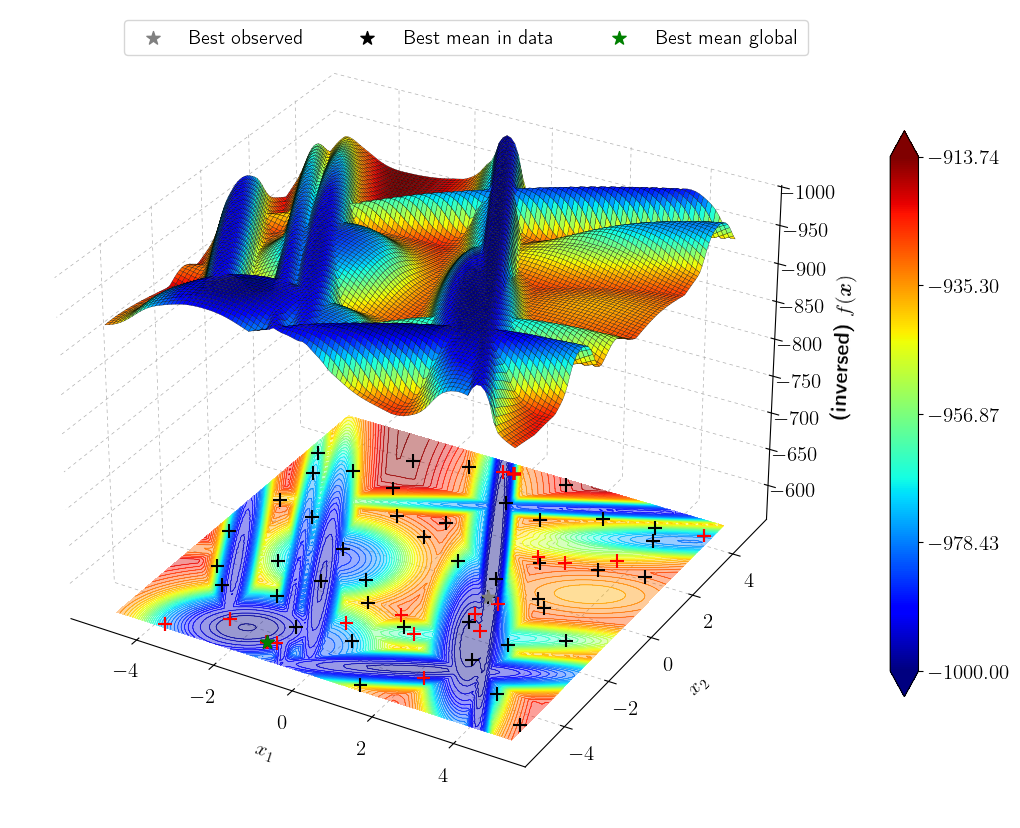

In [96]:
import FewShotCVRP.utils.plots as myplots

myplots.good_plt_config()
fig, ax = myplots.plot_3D_surface(
    (-5, 5),
    (-5, 5),
    f,
    res["X"][:50],
    is_axis_names=True,
    is_white_facecolor=True,
    is_colorbar=True,
    discretization=100,
    zfactor=2.0,
    is_inverse=True,
    scatter_search_space_color="black"
)
zax_min, zax_max = ax.get_zlim()
ax.scatter(
    res["X"][50:, 0],
    res["X"][50:, 1],
    zax_min,
    c="red",
    marker="+",
    s=100,
    alpha=1,
    zorder=4,
)
ax.scatter(
    res["x_obs_best"][0],
    res["x_obs_best"][1],
    zax_min,
    c="grey",
    marker="*",
    s=100,
    alpha=1,
    zorder=4,
    label="Best observed",
)
ax.scatter(
    res["x_rec_mean_in_data"][0],
    res["x_rec_mean_in_data"][1],
    zax_min,
    c="black",
    marker="*",
    s=100,
    alpha=1,
    zorder=4,
    label="Best mean in data",
)
ax.scatter(
    res["x_rec_mean_global"][0],
    res["x_rec_mean_global"][1],
    zax_min,
    c="green",
    marker="*",
    s=100,
    alpha=1,
    zorder=4,
    label="Best mean global",
)
ax.legend(ncols=3)

### Debug fitting GP on manifold of NN

In [106]:
from importlib import reload
from pathlib import Path

import joblib
import FewShotCVRP.bo.gp_fitting as gp_fitting
import FewShotCVRP.bo.kpcabo.kpcabo_torch as kpcabo_torch
import FewShotCVRP.bo.bo_torch as bo_torch
import FewShotCVRP.utils.logs as logs

reload(gp_fitting)
reload(bo_torch)
reload(kpcabo_torch)

logs.configure_logger("FewShotCVRPLogger")

precomputed = joblib.load(Path("../params_search/precomputed_DoEs.joblib"))
arrays = precomputed["X-n209-k16.xml"]
X_init = arrays["X_"]
y_init = arrays["y_"]
bounds = arrays["bounds"]

mll_fit_cfg = gp_fitting.MLLFitConfig(
    noise_bounds=(1.0, 1000.0),
    init_lengthscales_with_vanilla_bo=True,
    refine_with_grad=True,
    verbose=False,
)

bo_embedding_kwargs = {
    "X_init": X_init,
    "y_init": y_init,
    "doe_method": "precomputed",
    "sigma": 700.0,
    "kernel": "matern",
    "matern_nu": 2.5,
    "kernel_isotropic": False,
    "use_input_normalize": True,
    "normalize_y": True,
    "add_vanilla_bo_prior": True,
    "acq_function": "logEI",
    "n_init_samples_acq_opt": 10_000,
    "n_restarts_acq_opt": 100,
    "suggestions_per_step": 10,
    "diversity_frac": 0.1,
    "mll_fit_config": mll_fit_cfg,
}

kpcabo = kpcabo_torch.KPCABayesianOptimizer(
    func=f,
    f_batch=None,
    bounds=bounds,
    kpca_eta=0.9,
    kpca_pad_frac=0.10,
    kpca_refit_trigger=0.20,
    max_preimage_anchors=3,
    preimage_budget=100000,
    n_init=None,
    n_iter=1,
    random_state=1,
    bo_embedding_kwargs=bo_embedding_kwargs,
)

# res = kpcabo.run()

kpcabo.bo_embedding_kwargs.update({"bounds": kpcabo.bounds})
kpcabo.bo_embedding_kwargs.update({"n_init": kpcabo.n_init})
bo_embedding = bo_torch.BayesianOptimizer(
    func=kpcabo.func, f_batch=kpcabo.f_batch, **kpcabo.bo_embedding_kwargs
)
bo_embedding._initialize_design()
kpcabo.X_np_ = bo_torch._to_numpy64(bo_embedding.X_)
kpcabo.y_np_ = bo_torch._to_numpy64(bo_embedding.y_)
kpcabo._fit_kpca()

# 1) Refit GP in z-space for next round
bo_embedding = kpcabo._create_bo_embedding()
bo_embedding._fit_gp()

# 2) Optimize EI in z-space
Z_new_t, _ = bo_embedding._argmax_acq_multi(bo_embedding.suggestions_per_step)
Z_new_obj_values_approx, _ = bo_embedding.posterior(Z_new_t, return_std=False)
Z_new = bo_torch._to_numpy64(Z_new_t)


[09/20/25 21:09:13] INFO     Refitting Kernel-PCA triggered

[09/20/25 21:09:28] INFO     Dimensionality of the embedding space: 128

                    INFO     Refitting Kernel-PCA done! fit_kpca took 0:00:14.807049

                    INFO     Found lengthscales parameters, shape: torch.Size([128])

                    INFO     Found constant mean parameter, shape: torch.Size([])

                    INFO     GP fitting initial log likelihood: -22.268229

[09/20/25 21:11:50] INFO     GP fitting after CMA-ES log likelihood: -1.355836

[09/20/25 21:11:53] INFO     [LBFGSB 0005] | log likelihood: -0.410605

[09/20/25 21:11:56] INFO     [LBFGSB 0010] | log likelihood: -0.378703

[09/20/25 21:11:59] INFO     [LBFGSB 0015] | log likelihood: -0.375944

[09/20/25 21:12:03] INFO     [LBFGSB 0020] | log likelihood: -0.373545

[09/20/25 21:12:07] INFO     [LBFGSB 0025] | log likelihood: -0.371229

[09/20/25 21:12:10] INFO     [LBFGSB 0030] | log likelihood: -0.370967

[09/20/25 21:12:13] INFO     [LBFGSB 0035] | log likelihood: -0.370230

[09/20/25 21:12:18] INFO     [LBFGSB 0040] | log likelihood: -0.363917

[09/20/25 21:12:21] INFO     [LBFGSB 0045] | log likelihood: -0.361408

[09/20/25 21:12:24] INFO     [LBFGSB 0050] | log likelihood: -0.360256

[09/20/25 21:12:27] INFO     [LBFGSB 0055] | log likelihood: -0.360006

[09/20/25 21:12:30] INFO     [LBFGSB 0060] | log likelihood: -0.359341

[09/20/25 21:12:34] INFO     [LBFGSB 0065] | log likelihood: -0.355914

[09/20/25 21:12:37] INFO     [LBFGSB 0070] | log likelihood: -0.354324

[09/20/25 21:12:39] INFO     GP fitting final log likelihood: -0.354305 | status=1

                    INFO     fit_gp took 0:03:10.754009

[09/20/25 21:14:49] INFO     EI scores (selected): [10.1526, 10.1526, 10.1526, 10.1526, 10.1526, 10.1526, 10.1526, 
                             10.1526] (+2 more) | baseline(start) ≈ 8.62594

                    INFO     argmax_acq took 0:02:10.616849

In [108]:
# 3) Back-map to x-space
X_new_np = kpcabo._find_preimages(Z_new, Z_new_obj_values_approx)

[09/20/25 21:30:26] INFO     Preimage location final quality: 1.008822

[09/20/25 21:30:27] INFO     Preimage location final quality: 1.006227

[09/20/25 21:30:28] INFO     Preimage location final quality: 1.004721

[09/20/25 21:30:29] INFO     Preimage location final quality: 1.008113

[09/20/25 21:30:30] INFO     Preimage location final quality: 1.003654

[09/20/25 21:30:31] INFO     Preimage location final quality: 1.006418

[09/20/25 21:30:32] INFO     Preimage location final quality: 1.003860

[09/20/25 21:30:33] INFO     Preimage location final quality: 1.010059

[09/20/25 21:30:34] INFO     Preimage location final quality: 1.006889

                    INFO     Preimage location final quality: 1.006391

                    INFO     find_preimages took 0:06:11.086461

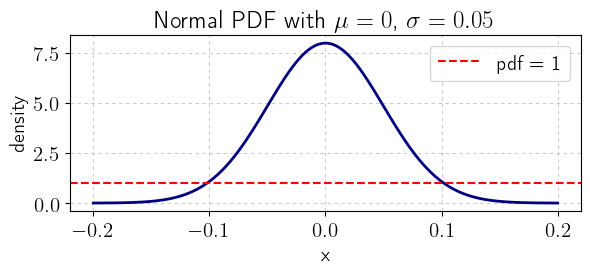

In [101]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# sns.set_theme(style="whitegrid")

mu = 0.0
sigma = 0.05
x = np.linspace(-0.2, 0.2, 500)
pdf = (1.0 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

plt.figure(figsize=(6, 3))
sns.lineplot(x=x, y=pdf, color="navy", linewidth=2)
plt.axhline(1.0, color="red", linestyle="--", label="pdf = 1")
plt.title(r"Normal PDF with $\mu=0$, $\sigma=0.05$")
plt.xlabel("x")
plt.ylabel("density")
plt.legend()
plt.tight_layout()
plt.show()
